## Introduction
The below code creates models used for assessing affordability for My Community Finance loan applicants.

The final model used was Model 3

1. Default Model - uses missed payments as the Y variable
2. Affordability risk categories - uses income after repay as the Y variable to calculate their affordability risk group
3. Model Afford Flag - this is the final model used and uses a calculated column afford_flag as the Y variable and produces the most important factors from the Applicant & Bureau data sets which impact afford_flag. 

- The same model was run adding in Summary data to compare model results, the Applicant & Bureau data model produced the best results.

####  Import necessary packages and libraries.

In [1]:
# Import packages and libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.formula.api import ols

import statsmodels.stats.api as sms
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

### Load CSV file from EDA 
- 1.Team8_LSE_EP_Assignment3_EDA

In [2]:
# Load the csv file 
df_model = pd.read_csv('df_model.csv')
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17608 entries, 0 to 17607
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uuid                           17608 non-null  object 
 1   date_created_x                 17608 non-null  object 
 2   amount_requested               17608 non-null  int64  
 3   duration_requested             17608 non-null  int64  
 4   reason                         17608 non-null  object 
 5   annual_salary                  17608 non-null  int64  
 6   dependant_number               17608 non-null  int64  
 7   dependants_spend               17608 non-null  float64
 8   has_mortgage_x                 17608 non-null  object 
 9   monthly_spending               17608 non-null  int64  
 10  rent_mortgage_spend            17608 non-null  float64
 11  employment_status              17608 non-null  object 
 12  number_applications            17608 non-null 

# MODELS

## 1. Default Model
> 
- This was our initial model using '2+ missed payments past 36 months' as the Y variable. After feedback on the initial pitch from MCF we changed the model to use an affordability flag as the Y variable (see below). Model has been left in code for reference.

In [3]:
# Create a copy from original dataframe
df_model_1 = df_model.copy()

In [4]:
# Drop columns that are included on missed_payment.
df_model_1 = df_model_1.drop(['ccj_flag','missed_2+_payments_past_36m', 'o1','o2', 'o3'], axis=1)

# Drop other unnecessary columns
df_model_1 = df_model_1.drop(['uuid', 'date_created_x','has_mortgage_x','number_applications',
                          'tax', 'interest_rate', 'date_created_y', 'total_spend','salary_band_10000s', 
                          'salary_band_5000s'], axis=1)

In [5]:
# View columns
df_model_1.columns

Index(['amount_requested', 'duration_requested', 'reason', 'annual_salary',
       'dependant_number', 'dependants_spend', 'monthly_spending',
       'rent_mortgage_spend', 'employment_status', 'net_salary',
       'monthly_earnings', 'clusters', 'disposable_income', 'rejected',
       'repayment', 'income_after_repay', 'new_to_credit_on_date_created',
       'credit_score_100s', 'has_mortgage_y', 'self_employed_flag',
       'missed_payment', 'DTI'],
      dtype='object')

In [6]:
# Change missed payment to 0 or 1
df_model_1['missed_payment'] = np.where(df_model_1['missed_payment'] != 0, 1, 0)

# Change Rejected column to 1 and 0
df_model_1['rejected'] = df_model_1['rejected'].astype(int)
print(df_model_1['rejected'].info)

# Change has_mortgage column to 1 and 0
df_model_1['has_mortgage_y'] = df_model_1['has_mortgage_y'].astype(int)
df_model_1['has_mortgage_y'].info

<bound method Series.info of 0        0
1        0
2        0
3        0
4        0
        ..
17603    0
17604    0
17605    0
17606    0
17607    0
Name: rejected, Length: 17608, dtype: int32>


<bound method Series.info of 0        0
1        0
2        0
3        0
4        0
        ..
17603    0
17604    0
17605    1
17606    1
17607    1
Name: has_mortgage_y, Length: 17608, dtype: int32>

In [7]:
# Create binary (dummy) variables
df_model_1 = pd.get_dummies(df_model_1, columns=['reason', 'employment_status', 'clusters'], drop_first=True)

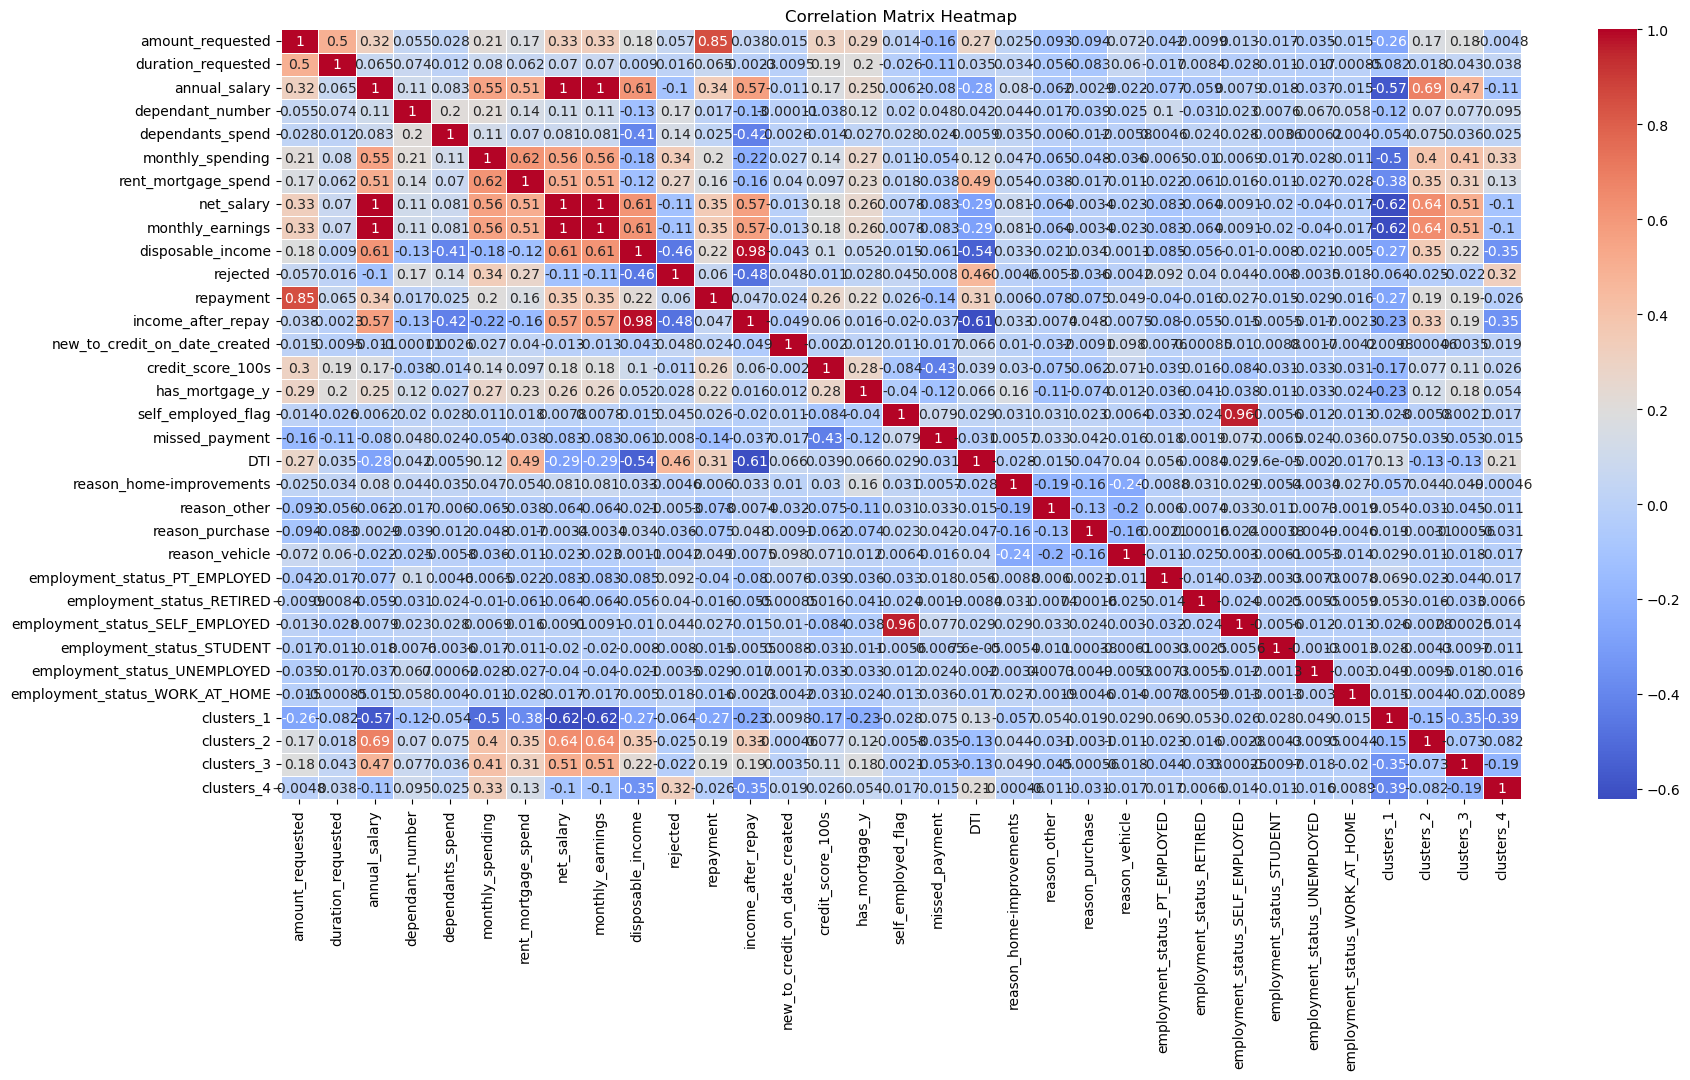

In [8]:
# Calculate the correlation matrix
model1_corr = df_model_1.corr()

# Display the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(model1_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [9]:
# Drop correlated columns.
df_model_1 = df_model_1.drop(['monthly_earnings', 'annual_salary','employment_status_SELF_EMPLOYED','net_salary',
                          'rent_mortgage_spend', 'monthly_spending', 'dependants_spend', 'disposable_income',
                          'repayment', 
                          ], axis=1)

In [10]:
# Define the dependent variable.
y = df_model_1['missed_payment']

# Define the independent variable.
X = df_model_1.drop(['missed_payment'], axis = 1)

In [11]:
# Add a constant to the X dataframe
X_const = add_constant(X)

# Identify multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i)
                          for i in range(len(X_const.columns))]

# View the DataFrame.
vif_data.sort_values('VIF', ascending=True)

,feature,VIF
17,employment_status_STUDENT,1.002014
19,employment_status_WORK_AT_HOME,1.008148
18,employment_status_UNEMPLOYED,1.010133
16,employment_status_RETIRED,1.016915
6,new_to_credit_on_date_created,1.017010
9,self_employed_flag,1.022270
15,employment_status_PT_EMPLOYED,1.028551
3,dependant_number,1.122118
13,reason_purchase,1.155138
7,credit_score_100s,1.182567


**Observations**
VIF shows low multicollinarity between variables, as all the variables were under 5 when a constant was added.

In [12]:
# Create train and test data sets.
X_train, X_test, y_train, y_test = train_test_split(X_const, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
# Create a function, and set values.
scaler = MinMaxScaler(feature_range = (0, 1))  

# Add the X_train data set to the 'scaler' function.
scaler.fit(X_train)

# Specify X_train data set.
X_train = scaler.transform(X_train) 
X_train = pd.DataFrame(X_train, columns=X_const.columns)

# Specify X_test data set. 
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_const.columns)

In [14]:
# Reset index to ensure that the index starts from 0
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
# Logistic Regression model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [16]:
# Prediction model
y_pred = logmodel.predict(X_test)

# Print classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3266
           1       0.57      0.21      0.30       256

    accuracy                           0.93      3522
   macro avg       0.76      0.60      0.63      3522
weighted avg       0.91      0.93      0.92      3522



> The model has 93% accuracy, 21% recall and 57% precision.

----------

#### Random Forest
As above this random forest is using missed 2+ payments in past 36 months as the Y variable.
After feedback from the MCF team we used a different Y variable (see below afford_flag). This model has been left in the code for reference.

In [17]:
# Import necessary package.
from sklearn.ensemble import RandomForestClassifier

# Create a model.
forest = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                min_samples_split=2, min_samples_leaf=2, 
                                max_features='auto', bootstrap=True, n_jobs=-1, 
                                random_state=42)

# Fit the model.
forest.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [18]:
# Importance values
forest.feature_importances_

array([0.00000000e+00, 1.01206983e-01, 6.11346046e-02, 4.31667277e-02,
       6.85285310e-03, 1.54448925e-01, 8.60281482e-03, 3.40959184e-01,
       1.51602171e-02, 1.35815537e-02, 1.56685164e-01, 1.46925087e-02,
       1.40304928e-02, 1.14008623e-02, 1.54325728e-02, 3.43560769e-03,
       2.13125134e-03, 1.44602982e-05, 1.54306504e-03, 1.56558171e-03,
       1.58795770e-02, 1.23278660e-03, 7.41725558e-03, 9.42495087e-03])

In [19]:
# Feature importances
feature_df = pd.DataFrame({'feature': X_const.columns, 
                           'feature_importnces':forest.feature_importances_}).sort_values(by='feature_importnces',ascending=False)
feature_df

,feature,feature_importnces
7,credit_score_100s,0.340959
10,DTI,0.156685
5,income_after_repay,0.154449
1,amount_requested,0.101207
2,duration_requested,0.061135
3,dependant_number,0.043167
20,clusters_1,0.015880
14,reason_vehicle,0.015433
8,has_mortgage_y,0.015160
11,reason_home-improvements,0.014693


**Observations** The train data set indicated that Credit Score was the highest factor impacting affordability (using missed payment past 36 months as the Y variable).

In [20]:
y_pred = forest.predict(X_test)

# Print classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3266
           1       0.42      0.05      0.10       256

    accuracy                           0.93      3522
   macro avg       0.68      0.52      0.53      3522
weighted avg       0.89      0.93      0.90      3522



**Observations** the unbalanced train data set model has an accuracy of 93%, but recall of only 5% and precision of 42%. Suggest testing the model with balanced data to improve the model's results.

------------------

### Balance the data and re-run the model

In [21]:
# Define the dependent variable.
y = df_model_1['missed_payment']

# Define the independent variable.
X = df_model_1.drop(['missed_payment'], axis=1)

# Add a constant to the X dataframe
X_const = add_constant(X)

# Create train and test data sets.
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.2, random_state=42)

# Handling Imbalanced Data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Import the MinMaxScaler to normalize the data.
scaler = MinMaxScaler(feature_range=(0, 1))

# Add the X_train_resampled data set to the 'scaler' function.
scaler.fit(X_train_resampled)

# Specify X_train and X_test data sets.
X_train_resampled = scaler.transform(X_train_resampled)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_const.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_const.columns)

# Reset index to ensure that the index starts from 0
y_train_resampled = y_train_resampled.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Logistic Regression model
logmodel = LogisticRegression()
logmodel.fit(X_train_resampled, y_train_resampled)

# Prediction model
y_pred = logmodel.predict(X_test)

# Print classification_report
print(classification_report(y_test, y_pred))

# AUC-ROC for Logistic Regression
y_pred_prob_log = logmodel.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, y_pred_prob_log)
print(f"AUC-ROC for Logistic Regression: {auc_log:.2f}")

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      3266
           1       0.30      0.63      0.40       256

    accuracy                           0.86      3522
   macro avg       0.63      0.76      0.66      3522
weighted avg       0.92      0.86      0.89      3522

AUC-ROC for Logistic Regression: 0.86


In [22]:
# Random Forest Classifier
forest = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto', bootstrap=True, 
                                n_jobs=-1, random_state=42)
forest.fit(X_train_resampled, y_train_resampled)

# Importance values
forest.feature_importances_

# Feature importances
feature_df = pd.DataFrame({'feature': X_const.columns, 
                           'feature_importnces':forest.feature_importances_}).sort_values(by='feature_importnces',ascending=False)
print(feature_df)

                           feature  feature_importnces
7                credit_score_100s            0.469205
2               duration_requested            0.092051
8                   has_mortgage_y            0.074492
1                 amount_requested            0.067222
5               income_after_repay            0.051141
9               self_employed_flag            0.042602
10                             DTI            0.039622
14                  reason_vehicle            0.026871
6    new_to_credit_on_date_created            0.022345
12                    reason_other            0.020674
11        reason_home-improvements            0.018811
22                      clusters_3            0.018492
23                      clusters_4            0.013498
13                 reason_purchase            0.012435
3                 dependant_number            0.012026
20                      clusters_1            0.010681
4                         rejected            0.002734
21        

In [23]:
# Prediction model
y_pred_forest = forest.predict(X_test)

# Print classification_report
print(classification_report(y_test, y_pred_forest))

# AUC-ROC for Random Forest
y_pred_prob_forest = forest.predict_proba(X_test)[:, 1]
auc_forest = roc_auc_score(y_test, y_pred_prob_forest)
print(f"AUC-ROC for Random Forest: {auc_forest:.2f}")

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3266
           1       0.36      0.39      0.37       256

    accuracy                           0.91      3522
   macro avg       0.66      0.67      0.66      3522
weighted avg       0.91      0.91      0.91      3522

AUC-ROC for Random Forest: 0.89


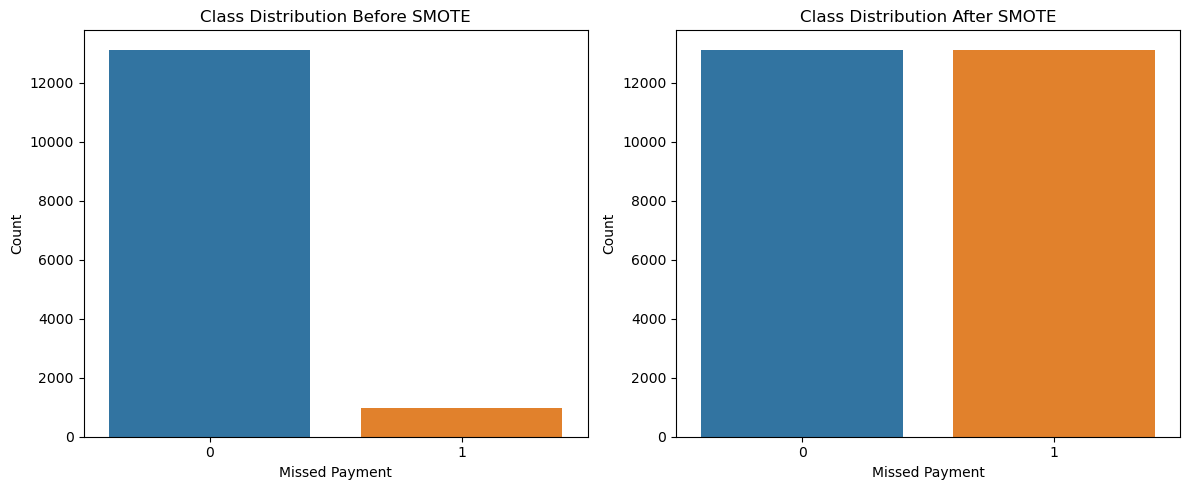

In [24]:
# 1. Class Distribution Before and After SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Missed Payment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(y_train_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Missed Payment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

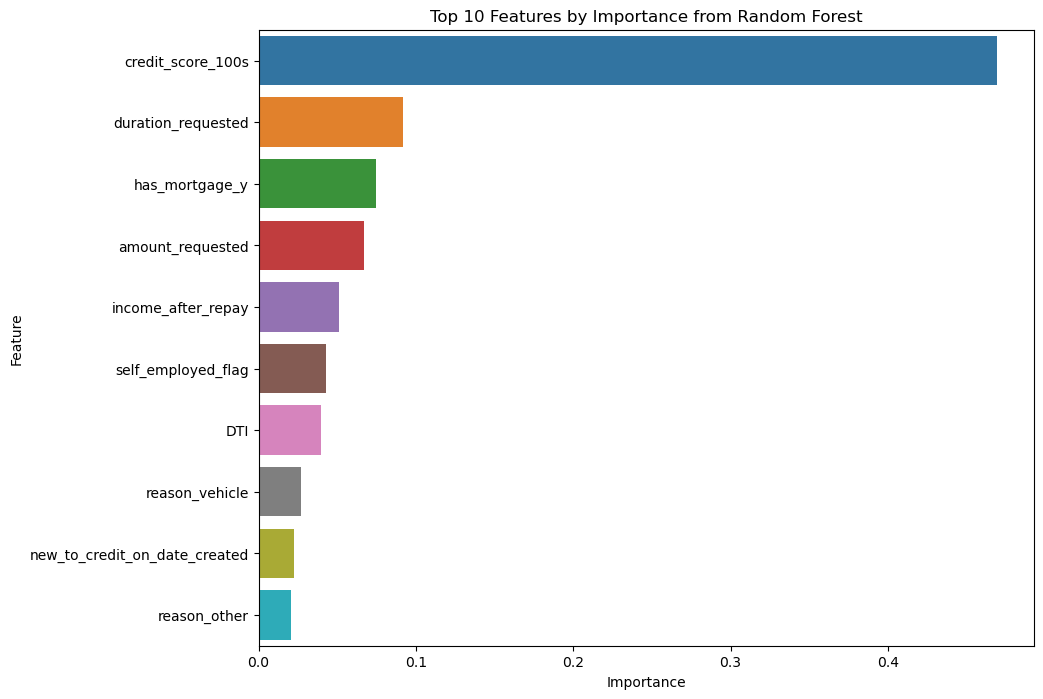

In [25]:
# 2. Feature Importance from Random Forest
plt.figure(figsize=(10, 8))
sns.barplot(x='feature_importnces', y='feature', data=feature_df.head(10))
plt.title('Top 10 Features by Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

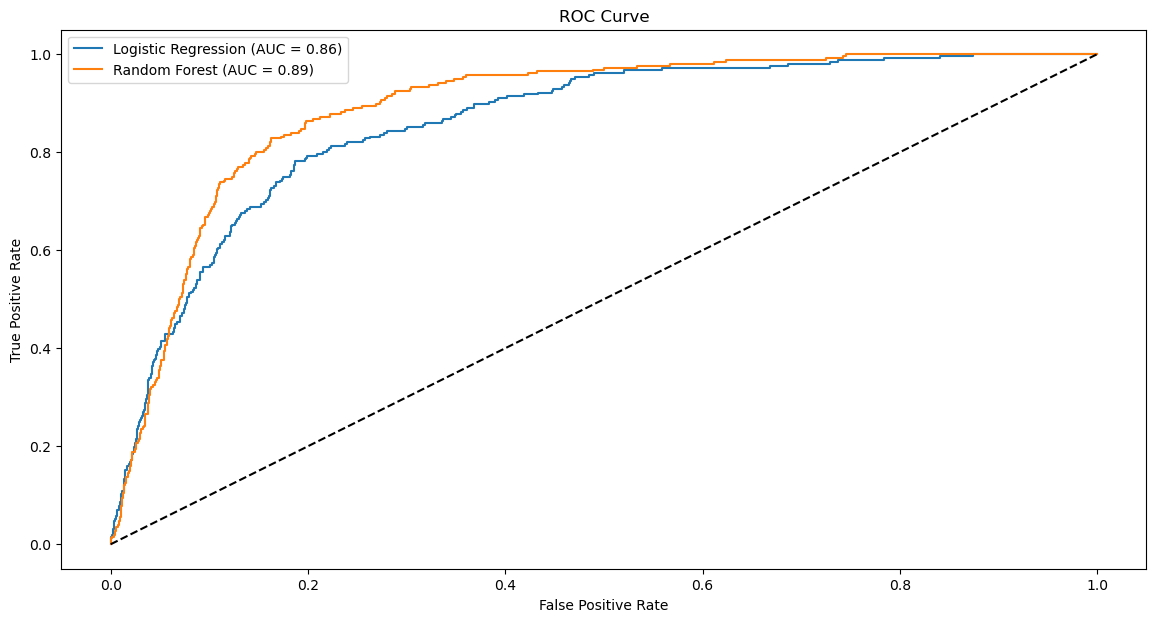

In [26]:
# 3. ROC Curves for Both Models
from sklearn.metrics import roc_curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob_log)
fpr_forest, tpr_forest, _ = roc_curve(y_test, y_pred_prob_forest)

plt.figure(figsize=(14, 7))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})')
plt.plot(fpr_forest, tpr_forest, label=f'Random Forest (AUC = {auc_forest:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Summary:
> Both models have performed well in predicting whether a customer will miss a payment or not.
The Random Forest model slightly outperforms the Logistic Regression model in terms of accuracy and AUC-ROC score.

> The Logistic Regression model, despite its lower precision for the positive class (missed payment), has a higher recall, meaning it's better at identifying potential missed payments, but at the cost of more false positives.

> The Random Forest model provides a balanced performance between precision and recall for the positive class.
The feature importance from the Random Forest model highlights the significance of features like credit_score_100s, has_mortgage_y, duration_requested and amount_requested in determining the likelihood of a customer missing a payment.

> The original data had only a small percentage of applicants with a missed payment. When the data was balanced using SMOTE it  improved the model's recall, but the accuracy and precision dropped slightly.


-------------------

----------------

## 2. Affordability Risk Categories
 We created a model to assess the affordability risk categories. The model used income after repayment as the dependent variable. We then applied a threshold to the model's output to classify applicants into four categories: low risk, moderate risk, high risk, and rejected. We further adjusted the risk level of each applicant based on their historical payment record. Applicants who had missed payments in the past were moved to the next higher-risk category.
 > **Low Risk:** Those with the highest 'income_after_repay' values. These individuals have the biggest financial cushion, making them the least likely to default on new financial obligations.

> **Moderate Risk:** Those with 'income_after_repay' values in the middle range. 

> **High Risk:** Those with the lowest 'income_after_repay' values. These individuals have the least financial flexibility and are more susceptible to financial shocks.

> **Rejected:** Those below a certain threshold might be considered too risky to be given any financial product or service.

In [27]:
# Create a copy from original dataframe
df_model_2 = df_model.copy()

In [28]:
# Drop columns that are included on missed_payment.
df_model_2 = df_model_2.drop(['ccj_flag','missed_2+_payments_past_36m', 'o1','o2', 'o3'], axis=1)

# Drop other unnecessary columns
df_model_2 = df_model_2.drop(['uuid', 'date_created_x','has_mortgage_x','number_applications',
                          'tax', 'interest_rate', 'date_created_y', 'total_spend','salary_band_10000s', 
                          'salary_band_5000s'], axis=1)

In [29]:
# Determine the thresholds based on the specified percentiles
low_risk_threshold = df_model_2['income_after_repay'].quantile(0.65)
moderate_risk_threshold = df_model_2['income_after_repay'].quantile(0.45)
high_risk_threshold = df_model_2['income_after_repay'].quantile(0.25)

# Function to categorize risk based on income_after_repay
def categorize_risk(value):
    if value >= low_risk_threshold:
        return 'Low Risk'
    elif value >= moderate_risk_threshold:
        return 'Moderate Risk'
    elif value >= high_risk_threshold:
        return 'High Risk'
    else:
        return 'Rejected'

# Apply the function to the dataframe
df_model_2['risk_category'] = df_model_2['income_after_repay'].apply(categorize_risk)

df_model_2.head()

,amount_requested,duration_requested,reason,annual_salary,dependant_number,dependants_spend,monthly_spending,rent_mortgage_spend,employment_status,net_salary,...,rejected,repayment,income_after_repay,new_to_credit_on_date_created,credit_score_100s,has_mortgage_y,self_employed_flag,missed_payment,DTI,risk_category
0,3500,24,home-improvements,72500,0,0.0,500,0.0,FT_EMPLOYED,56068.0,...,False,181.919407,3990.413927,0.0,300.0,0.0,0.0,0.0,3.011080,Low Risk
1,10000,60,debt,38079,1,400.0,1000,350.0,FT_EMPLOYED,32977.2,...,False,277.327456,720.772544,0.0,500.0,0.0,0.0,0.0,19.769241,High Risk
2,10000,48,vehicle,34500,0,0.0,1400,775.0,FT_EMPLOYED,30114.0,...,False,316.147570,18.352430,0.0,400.0,0.0,0.0,0.0,37.952959,Rejected
3,8500,60,debt,18000,0,0.0,500,180.0,FT_EMPLOYED,16914.0,...,False,235.728337,493.771663,0.0,500.0,0.0,0.0,0.0,27.715222,High Risk
4,7000,60,other,25000,0,0.0,650,0.0,FT_EMPLOYED,22514.0,...,False,194.129219,1032.037448,0.0,400.0,0.0,0.0,0.0,9.318203,Moderate Risk


In [30]:
# Adjusting for missed_payments
df_model_2.loc[(df_model_2['missed_payment'] == 1) & (df_model_2['risk_category'] == 'Low Risk'), 'risk_category'] = 'Moderate Risk'
df_model_2.loc[(df_model_2['missed_payment'] == 1) & (df_model_2['risk_category'] == 'Moderate Risk'), 'risk_category'] = 'High Risk'
df_model_2.loc[(df_model_2['missed_payment'] == 1) & (df_model_2['risk_category'] == 'High Risk'), 'risk_category'] = 'Rejected'

# Checking the distribution of the new risk categories
risk_distribution = df_model_2['risk_category'].value_counts()
print(risk_distribution)

# Checking the distribution in %
risk_distribution = df_model_2['risk_category'].value_counts(normalize=True)
risk_distribution

Low Risk         5940
Rejected         4985
Moderate Risk    3350
High Risk        3333
Name: risk_category, dtype: int64


Low Risk         0.337347
Rejected         0.283110
Moderate Risk    0.190254
High Risk        0.189289
Name: risk_category, dtype: float64

> Low Risk: Approximately 5940 - 33.7% of the entries fall into the "Low Risk" category.

> Reject: Approximately 4985 - 28.3% of the entries fall into the "Reject" category.

> Moderate Risk: Approximately 3350 - 19% of the entries fall into the "Moderate Risk" category.

> High Risk: Approximately 3333 - 18.9% of the entries fall into the "High Risk" category.

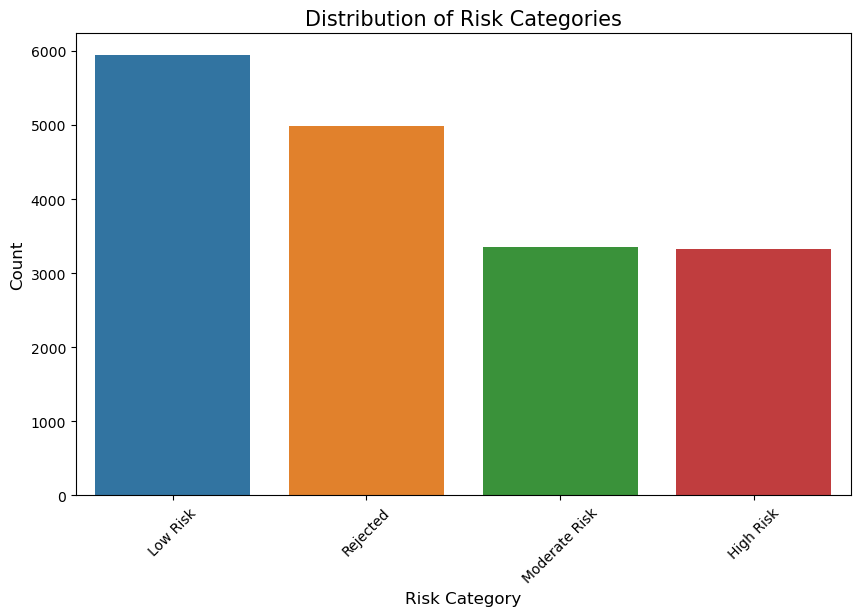

In [31]:
# Create a bar plot for the risk categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df_model_2, x='risk_category', order=df_model_2['risk_category'].value_counts().index)

# Set the title and labels
plt.title('Distribution of Risk Categories', fontsize=15)
plt.xlabel('Risk Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [32]:
# Check correlation
correlation_matrix = df_model_2.corr()

target_correlation = correlation_matrix['income_after_repay'].sort_values(ascending=False)
print(target_correlation)

income_after_repay               1.000000
disposable_income                0.984993
net_salary                       0.567143
monthly_earnings                 0.567143
annual_salary                    0.566148
credit_score_100s                0.060211
repayment                        0.047050
amount_requested                 0.038144
has_mortgage_y                   0.015672
duration_requested              -0.002250
self_employed_flag              -0.019583
missed_payment                  -0.021492
new_to_credit_on_date_created   -0.048624
dependant_number                -0.132666
rent_mortgage_spend             -0.155139
monthly_spending                -0.222268
clusters                        -0.234595
dependants_spend                -0.420484
rejected                        -0.478312
DTI                             -0.611394
Name: income_after_repay, dtype: float64


> DTI stands out as a strong predictor given its high negative correlation.

In [33]:
# Change missed payment to 0 or 1
df_model_2['missed_payment'] = np.where(df_model_2['missed_payment'] != 0, 1, 0)

# Change Rejected column to 1 and 0
df_model_2['rejected'] = df_model_2['rejected'].astype(int)

# Change has_mortgage column to 1 and 0
df_model_2['has_mortgage_y'] = df_model_2['has_mortgage_y'].astype(int)

In [34]:
# Create binary (dummy) variables
df_model_2 = pd.get_dummies(df_model_2, columns=['reason', 'employment_status', 'clusters'], drop_first=True)

In [35]:
# Convert risk labels into numerical values
mapping = {
    'Low Risk': 1,
    'Rejected': 2,
    'Moderate Risk': 3,
    'High Risk': 4
}
df_model_2['risk_category'] = df_model_2['risk_category'].map(mapping)

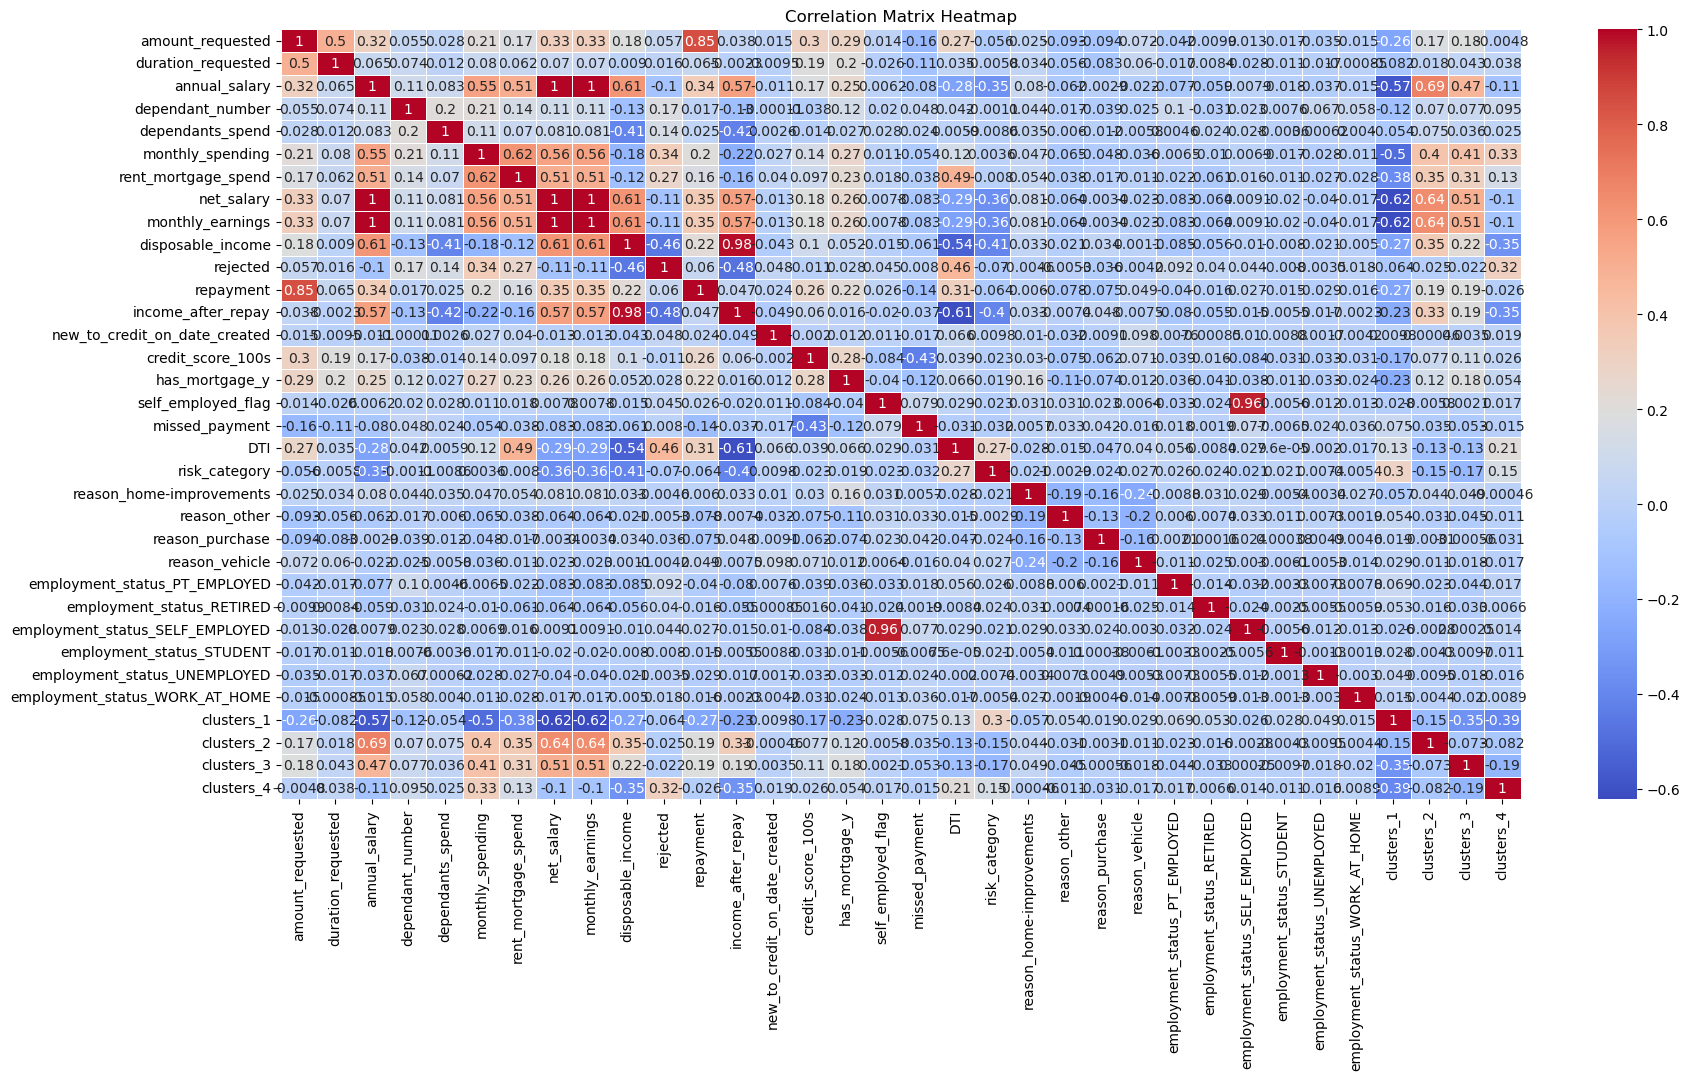

In [36]:
# Calculate the correlation matrix
model2_corr = df_model_2.corr()

# Display the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(model2_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [37]:
# Drop correlated columns.
df_model_2 = df_model_2.drop(['monthly_earnings', 'annual_salary','net_salary', 'employment_status_SELF_EMPLOYED',
                          'rent_mortgage_spend', 'monthly_spending', 'dependants_spend', 'disposable_income',
                          'repayment', 
                          ], axis=1)

In [38]:
# Define the dependent variable.
y = df_model_2['income_after_repay']
X = df_model_2.drop(['income_after_repay'], axis=1)

In [39]:
# Add a constant to the predictor variables
X_with_const = sm.add_constant(X)

# calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns

vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(len(X_with_const.columns))]


vif_data.sort_values(by="VIF", ascending=True)

,feature,VIF
18,employment_status_STUDENT,1.002652
20,employment_status_WORK_AT_HOME,1.008573
19,employment_status_UNEMPLOYED,1.010293
17,employment_status_RETIRED,1.014492
5,new_to_credit_on_date_created,1.017482
8,self_employed_flag,1.024492
16,employment_status_PT_EMPLOYED,1.028552
3,dependant_number,1.102214
14,reason_purchase,1.154623
22,clusters_2,1.173561


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the predictor variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Regressor
forest_regressor = RandomForestRegressor(n_estimators=200, min_samples_split=2, 
                                         min_samples_leaf=2, max_features='auto', bootstrap=True, 
                                         n_jobs=-1, random_state=42)

# Fit the model to the training data
forest_regressor.fit(X_train_scaled, y_train)

# Predict on the scaled test set
y_pred_forest = forest_regressor.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_forest)
mse = mean_squared_error(y_test, y_pred_forest)
r2 = r2_score(y_test, y_pred_forest)

mae, mse, r2

(203.13830812551828, 125141.08087182824, 0.8423054671827845)

**Results:**
> Mean Absolute Error (MAE): 203.13
On average, the model's predictions are approximately £203.33 from the actual values.

> Mean Squared Error (MSE): 125,141.08
Larger error. MSE indicates that there are some predictions that deviate significantly from the actual values. 

> R-squared: 0.8423 (or 84.23%): 
A relatively high R-squared value, indicates that approximately 84.17% of the income_after_repay variable is explained by the model.

-------------

------------

## 3. Model Afford Flag
This model used a calculated column called afford flag which used disposable income minus a cushion of 10% (which could be adjusted) and minus the loan repayment. 

When customers could not afford the loan the flag showed as 1. 

The model was applied to the Applicant & Bureau merged data to find the most important factors (variables) affecting the afford flag using a random forest model.

In [41]:
# Create a copy from original dataframe
df_model_3 = df_model.copy()

In [42]:
# Create dummy variables for column
df_model_dummy = pd.get_dummies(df_model_3['reason'], prefix='reason')

# Manually drop reason_other column
df_model_dummy.drop('reason_other', axis=1, inplace=True)

# Create dummy variables for the employment_status column
df_model_dummy2 = pd.get_dummies(df_model_3['employment_status'], prefix='employment')

# Manually drop self_employed column (there's a flag already for this) column
df_model_dummy2.drop('employment_SELF_EMPLOYED', axis=1, inplace=True)

# Concatenate the dummy variables with the original DataFrame
df_model_3 = pd.concat([df_model_3, df_model_dummy, df_model_dummy2], axis=1)

# Drop the original categorical columns
df_model_3 = df_model_3.drop(['reason', 'employment_status'], axis=1)

df_model_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17608 entries, 0 to 17607
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   uuid                           17608 non-null  object 
 1   date_created_x                 17608 non-null  object 
 2   amount_requested               17608 non-null  int64  
 3   duration_requested             17608 non-null  int64  
 4   annual_salary                  17608 non-null  int64  
 5   dependant_number               17608 non-null  int64  
 6   dependants_spend               17608 non-null  float64
 7   has_mortgage_x                 17608 non-null  object 
 8   monthly_spending               17608 non-null  int64  
 9   rent_mortgage_spend            17608 non-null  float64
 10  number_applications            17608 non-null  int64  
 11  tax                            17608 non-null  float64
 12  net_salary                     17608 non-null 

In [43]:
# creating a cushion
cushion = 0.10

def calculate_afford_flag(row):
    afford_flag = (row['disposable_income'] * (1 - cushion)) - row['repayment']
    return afford_flag

df_model_3['afford_flag'] = df_model_3.apply(calculate_afford_flag, axis=1)
df_model_3['afford_flag'] = np.where(df_model_3['afford_flag'] > 0, 0, 1)
df_model_3.head()

,uuid,date_created_x,amount_requested,duration_requested,annual_salary,dependant_number,dependants_spend,has_mortgage_x,monthly_spending,rent_mortgage_spend,...,reason_home-improvements,reason_purchase,reason_vehicle,employment_FT_EMPLOYED,employment_PT_EMPLOYED,employment_RETIRED,employment_STUDENT,employment_UNEMPLOYED,employment_WORK_AT_HOME,afford_flag
0,50b53986-7471-4197-9f2a-7d6287eae8fa,2021-10-31,3500,24,72500,0,0.0,unknown,500,0.0,...,1,0,0,1,0,0,0,0,0,0
1,d8c5c75e-a5d0-462c-b6aa-634877364f74,2021-10-31,10000,60,38079,1,400.0,unknown,1000,350.0,...,0,0,0,1,0,0,0,0,0,0
2,84057cd9-930f-469f-962b-711196323a15,2021-10-31,10000,48,34500,0,0.0,unknown,1400,775.0,...,0,0,1,1,0,0,0,0,0,1
3,99ac287b-9630-44e4-a74a-fc597d9dcb0d,2021-10-31,8500,60,18000,0,0.0,unknown,500,180.0,...,0,0,0,1,0,0,0,0,0,0
4,11ae07c4-8fd1-415e-a70e-145776ad0072,2021-10-31,7000,60,25000,0,0.0,unknown,650,0.0,...,0,0,0,1,0,0,0,0,0,0


In [44]:
# Checking how many fail affordability at 10% cushion.
count_afford_fail = df_model_3['afford_flag'].sum()

# Calculate the total number of rows in the DataFrame
total_rows = len(df_model_3)

# Calculate the percentage of 1s
percentage_fail = (count_afford_fail / total_rows) * 100

print(f"Number of applicants failing affordability: {count_afford_fail}")
print(f"Total rows: {total_rows}")
print(f"Percentage of applicants failing affordability: {percentage_fail:.2f}%")

Number of applicants failing affordability: 1975
Total rows: 17608
Percentage of applicants failing affordability: 11.22%


> **Observations** at 10% cushion 1975 applicants fail affordability - 11.22% of total applicants in the sample.

**Recommendations for future analysis**: The cushion could be adjusted depending on changes in the interest or inflation rates, or by customer segments (for example borderline customers who are a higher risk should be tested using a higher cushion, or those with dependant spend). Additionally the percentage cushion should be used an actual minimum amount for each applicant.

In [45]:
# checking afford flag is correct on a borderline case
# desired columns
desired_columns = ['uuid', 'disposable_income', 'repayment', 'afford_flag']
# Sample selected UUID
selected_uuid = "84057cd9-930f-469f-962b-711196323a15"

# Filter the DataFrame for the selected UUID and get the first row
selected_row = df_model_3[df_model_3['uuid'] == selected_uuid].head(1)

# Select the desired columns from the selected row
selected_row = selected_row[desired_columns]

# Print the selected row
print(selected_row)

                                   uuid  disposable_income  repayment  \
2  84057cd9-930f-469f-962b-711196323a15              334.5  316.14757   

   afford_flag  
2            1  


In [46]:
# Drop columns that are included on missed_payment.
df_model_3 = df_model_3.drop(['missed_2+_payments_past_36m', 'o1','o2', 'o3'], axis=1)

# Drop other unnecessary columns
df_model_3 = df_model_3.drop(['uuid', 'date_created_x','has_mortgage_x',
                          'tax', 'interest_rate', 'date_created_y', 'total_spend','salary_band_10000s', 
                          'salary_band_5000s'], axis=1)

In [47]:
# Calculate the correlation matrix
model3_corr = df_model_3.corr()

# Display the correlation matrix
model3_corr

,amount_requested,duration_requested,annual_salary,dependant_number,dependants_spend,monthly_spending,rent_mortgage_spend,number_applications,net_salary,monthly_earnings,...,reason_home-improvements,reason_purchase,reason_vehicle,employment_FT_EMPLOYED,employment_PT_EMPLOYED,employment_RETIRED,employment_STUDENT,employment_UNEMPLOYED,employment_WORK_AT_HOME,afford_flag
amount_requested,1.000000,0.496549,0.315425,0.055121,0.027522,0.209999,0.165835,0.039197,0.326261,0.326261,...,0.025405,-0.094378,0.071635,0.024394,-0.041872,-0.009918,-0.016883,-0.035406,-0.015190,0.071949
duration_requested,0.496549,1.000000,0.065098,0.074403,0.012232,0.079775,0.061527,0.052422,0.070039,0.070039,...,0.033894,-0.083038,0.060479,0.031193,-0.017185,0.008417,-0.011082,-0.017263,-0.000853,0.018451
annual_salary,0.315425,0.065098,1.000000,0.105631,0.083281,0.552594,0.505970,0.017351,0.995485,0.995485,...,0.080093,-0.002922,-0.021601,0.063498,-0.077066,-0.059298,-0.018158,-0.036888,-0.014607,-0.107576
dependant_number,0.055121,0.074403,0.105631,1.000000,0.203604,0.210806,0.142031,-0.011808,0.108017,0.108017,...,0.044425,-0.039499,-0.024999,-0.079482,0.099880,-0.030912,0.007583,0.066932,0.057883,0.169686
dependants_spend,0.027522,0.012232,0.083281,0.203604,1.000000,0.114880,0.069508,-0.009481,0.081434,0.081434,...,0.034608,-0.012079,-0.005789,-0.033132,0.004585,0.023594,-0.003581,0.000615,0.004007,0.135323
monthly_spending,0.209999,0.079775,0.552594,0.210806,0.114880,1.000000,0.618394,-0.005194,0.557355,0.557355,...,0.047337,-0.047998,-0.036420,0.010225,-0.006469,-0.010363,-0.016699,-0.027543,-0.011457,0.341579
rent_mortgage_spend,0.165835,0.061527,0.505970,0.142031,0.069508,0.618394,1.000000,0.005540,0.507497,0.507497,...,0.054092,-0.017121,-0.010759,0.031335,-0.021691,-0.061377,-0.010815,-0.027053,-0.028003,0.274254
number_applications,0.039197,0.052422,0.017351,-0.011808,-0.009481,-0.005194,0.005540,1.000000,0.020164,0.020164,...,-0.014524,-0.009828,0.001959,0.069131,-0.011929,-0.028131,0.000644,-0.013766,-0.016176,-0.007778
net_salary,0.326261,0.070039,0.995485,0.108017,0.081434,0.557355,0.507497,0.020164,1.000000,1.000000,...,0.081036,-0.003442,-0.022580,0.068513,-0.083484,-0.063993,-0.019899,-0.040221,-0.016647,-0.114373
monthly_earnings,0.326261,0.070039,0.995485,0.108017,0.081434,0.557355,0.507497,0.020164,1.000000,1.000000,...,0.081036,-0.003442,-0.022580,0.068513,-0.083484,-0.063993,-0.019899,-0.040221,-0.016647,-0.114373


In [48]:
# Drop correlated columns.
df_model_3 = df_model_3.drop(['monthly_earnings', 'annual_salary','net_salary',
                            'disposable_income', 'income_after_repay',  'clusters', 
                              'rejected','repayment', 
                          ], axis=1)

In [49]:
# Define the dependent variable.
y = df_model_3['afford_flag']

# Define the independent variable.
X = df_model_3.drop(['afford_flag'], axis=1)

In [50]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the X dataframe
X_const = sm.add_constant(X)

# Identify multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i)
                          for i in range(len(X_const.columns))]

# View the DataFrame.
vif_data.sort_values('VIF', ascending=True)

,feature,VIF
7,number_applications,1.015258
8,new_to_credit_on_date_created,1.019848
4,dependants_spend,1.053029
3,dependant_number,1.130238
22,employment_STUDENT,1.141103
10,has_mortgage_y,1.256243
13,missed_payment,1.329790
12,ccj_flag,1.332635
2,duration_requested,1.372955
9,credit_score_100s,1.394460


> **Observations** factors that have high multicollinarity are: employment_FT_EMPLOYED 19.85, self_employed_flag 12.21 and  employment_PT_EMPLOYED 5.55.

- We will use a random forest model which can handle multicollinearity to a significant extent.

In [51]:
# Add library for logistic regression
from sklearn.linear_model import LogisticRegression

# Add a constant to the X dataframe
X_const = sm.add_constant(X)

# Create train and test data sets.
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.2, random_state=42)

# Handling Imbalanced Data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Import the MinMaxScaler to normalize the data.
scaler = MinMaxScaler(feature_range=(0, 1))

# Add the X_train_resampled data set to the 'scaler' function.
scaler.fit(X_train_resampled)

# Specify X_train and X_test data sets.
X_train_resampled = scaler.transform(X_train_resampled)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_const.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_const.columns)

# Reset index to ensure that the index starts from 0
y_train_resampled = y_train_resampled.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [52]:
# Random Forest Classifier
forest = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto', bootstrap=True, 
                                n_jobs=-1, random_state=42)
forest.fit(X_train_resampled, y_train_resampled)

# Importance values
forest.feature_importances_

# Feature importances
feature_df = pd.DataFrame({'feature': X_const.columns, 
                           'feature_importnces':forest.feature_importances_}).sort_values(by='feature_importnces',ascending=False)
print(feature_df)

                          feature  feature_importnces
14                            DTI            0.346784
5                monthly_spending            0.216079
6             rent_mortgage_spend            0.099294
4                dependants_spend            0.084371
10                 has_mortgage_y            0.044293
1                amount_requested            0.024234
19         employment_FT_EMPLOYED            0.024111
9               credit_score_100s            0.022545
2              duration_requested            0.020740
16       reason_home-improvements            0.019551
18                 reason_vehicle            0.017942
15                    reason_debt            0.013804
3                dependant_number            0.013255
8   new_to_credit_on_date_created            0.012246
7             number_applications            0.011575
11             self_employed_flag            0.010311
17                reason_purchase            0.010282
13                 missed_pa

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3114
           1       0.77      0.75      0.76       408

    accuracy                           0.95      3522
   macro avg       0.87      0.86      0.87      3522
weighted avg       0.95      0.95      0.95      3522

AUC-ROC for Random Forest: 0.97


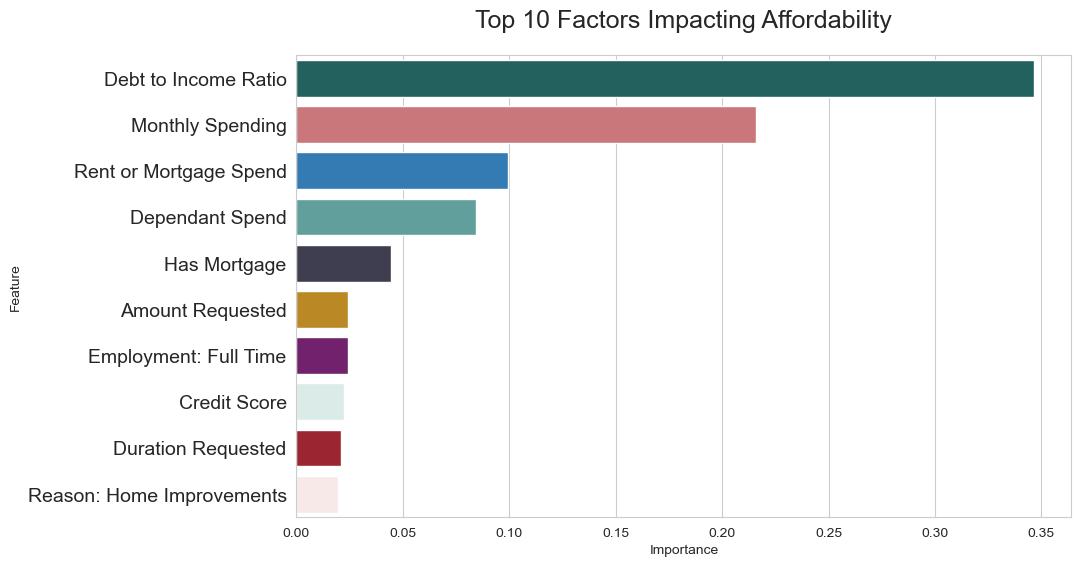

In [53]:
# Prediction model
y_pred_forest = forest.predict(X_test)

# Print classification_report
print(classification_report(y_test, y_pred_forest))

# AUC-ROC for Random Forest
y_pred_prob_forest = forest.predict_proba(X_test)[:, 1]
auc_forest = roc_auc_score(y_test, y_pred_prob_forest)
print(f"AUC-ROC for Random Forest: {auc_forest:.2f}")

# change the labels to use proper words instead of column headings
feature_df_copy = feature_df.copy()
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('DTI', 'Debt to Income Ratio')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('monthly_spending', 'Monthly Spending')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('rent_mortgage_spend', 'Rent or Mortgage Spend')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('dependants_spend', 'Dependant Spend')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('has_mortgage_y', 'Has Mortgage')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('credit_score_100s', 'Credit Score')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('amount_requested', 'Amount Requested')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('duration_requested', 'Duration Requested')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('reason_home-improvements', 'Reason: Home Improvements')
feature_df_copy['feature'] = feature_df_copy['feature'].str.replace('employment_FT_EMPLOYED', 'Employment: Full Time')

# Set brand MCF colours and style of plot
mcf_colors = ['#196b69', '#d8696f', '#1f7dc8', '#55aaa4', '#3d3b53', '#d3910d', '#801478', '#d9ede9', '#af1223', '#f9e7e6']
sns.set_style('whitegrid')


# 2. Feature Importance from Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='feature_importnces', y='feature', data=feature_df_copy.head(10), palette=mcf_colors)

# Increase the font size of the tick labels on both x and y axes
plt.yticks(fontsize=14)  # Adjust the font size as needed

plt.title('Top 10 Factors Impacting Affordability', pad=20, fontsize=18)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Comments 

- We will use the top 10 factors above (from the merged applicant and bureau data) as the basis for the weighted scorecard model.
- This was the best performing model for forecasting the most important factors affecting affordability with 95% accuracy, 75% recall and 77% precision.
- Monthly spend, Mortgage or Rent spend and Dependant spend have been left in as the VIF indicated low correlation between these, and it helps to understand the separate impact of housing, other spend and dependant spend.
- Has mortgage appears in the top 10, and this could have a higher significance over time if interest rates increase as fixed mortgage rates come to an end for individuals.
- Full time employment - the majority of applicants are in full time employment. If unemployment figures start to increase there may be a greater impact on full time employed applicants.
- Reason for the loan home improvements - over the long term this may positively impact the individual if the property is owned and home improvements add value to the home.

------------------

---------------

### Summary Data
As Open Banking data had more potential X variables than Applicant and Bureau data we wanted to test applying the random forest model to the summary data set to compare the random forest results. The model is below. 

However as the model delivered less accurate results than the Applicant & Bureau data set we have used the Applicant & Bureau data random forest model (above) in the weighted scorecard.

Summary Random Forest below is included for comparison, and may be used by MCF in future modelling or with a larger data sample.

In [54]:
# Load the csv file 
df_sum = pd.read_csv('summary_block.csv')

In [55]:
# Convert the 'date_created' column to datetime format
df_sum['date_created'] = pd.to_datetime(df_sum['date_created'],  format='%d/%m/%Y')

# Find the first and last date in the dataset
first_date = df_sum['date_created'].min()
last_date = df_sum['date_created'].max()

print(first_date)
print(last_date)

# Sort applicantion loan data by date
df_sum.sort_values(by=['date_created'], ascending=False, inplace=True)

# Select the rows from the DataFrame that you want to keep.
df_sum = df_sum.drop_duplicates(subset='uuid', keep='first')

2020-11-03 00:00:00
2021-10-31 00:00:00


In [56]:
# Check for missing values
missing_values = df_sum.isnull().sum()

# Columns with missing values 
missing_values[missing_values > 0]

high_balance_last_30_days                         398
high_balance_last_90_days                         318
high_balance_last_180_days                        278
high_balance_last_360_days                        238
low_balance_last_30_days                          398
low_balance_last_90_days                          318
low_balance_last_180_days                         278
low_balance_last_360_days                         238
avg_balance_last_30_days                          398
avg_balance_last_90_days                          318
avg_balance_last_180_days                         278
avg_balance_last_360_days                         238
essential_spending_over_income_last_30_days     14843
benefits_over_income_last_30_days               14843
savings_over_income_last_30_days                14843
gambling_over_income_last_30_days               14843
used_savings_last_30_days                       24342
used_bnpl_last_30_days                          24918
used_payday_last_30_days    

In [57]:
# Fill missing values for 'avg_balance_last_30_days' with its mean
df_sum['avg_balance_last_30_days'].fillna(df_sum['avg_balance_last_30_days'].mean(), inplace=True)

# Fill missing values for 'avg_balance_last_90_days' with its mean
df_sum['avg_balance_last_90_days'].fillna(df_sum['avg_balance_last_90_days'].mean(), inplace=True)

# Fill missing values for 'avg_balance_last_180_days' with its mean
df_sum['avg_balance_last_180_days'].fillna(df_sum['avg_balance_last_180_days'].mean(), inplace=True)

# Fill missing values for 'avg_balance_last_360_days' with its mean
df_sum['avg_balance_last_360_days'].fillna(df_sum['avg_balance_last_360_days'].mean(), inplace=True)

**Observations** as the summary data includes variables split into 30, 90, 180 and 360 days we wanted to reduce the number of columns to just use one consistent period.
Our preference was a longer time period as this would avoid any assumptions based on uncommon activity eg if the applicant moved house in the last 30 days they may have higher spend for that one month, by looking at a longer time period we would understand their typical spending or income patterns.
The minimum loan period is also 12 months (365 days), which indicates 360 day period would be best to understand their activity.
Comparing 180 to 360 days we found that the 2 columns in most cases correlated closely so used the 360 day column in our models.

In [58]:
#Create a dataframe with total income
total_income_broad = df_sum[['total_income_broad_last_30_days','total_income_broad_last_90_days',
                           'total_income_broad_last_180_days','total_income_broad_last_360_days']]
# View dataframe
total_income_cor = total_income_broad.corr()
total_income_cor

,total_income_broad_last_30_days,total_income_broad_last_90_days,total_income_broad_last_180_days,total_income_broad_last_360_days
total_income_broad_last_30_days,1.000000,0.881869,0.829502,0.770680
total_income_broad_last_90_days,0.881869,1.000000,0.964638,0.903472
total_income_broad_last_180_days,0.829502,0.964638,1.000000,0.958381
total_income_broad_last_360_days,0.770680,0.903472,0.958381,1.000000


In [59]:
#Create a dataframe with essential spends
net_essential = df_sum[['net_essential_spend_last_30_days','net_essential_spend_last_90_days',
                           'net_essential_spend_last_180_days','net_essential_spend_last_360_days']]
# View dataframe
net_essential_cor = net_essential.corr()
net_essential_cor

,net_essential_spend_last_30_days,net_essential_spend_last_90_days,net_essential_spend_last_180_days,net_essential_spend_last_360_days
net_essential_spend_last_30_days,1.000000,0.807130,0.622994,0.554672
net_essential_spend_last_90_days,0.807130,1.000000,0.860596,0.827891
net_essential_spend_last_180_days,0.622994,0.860596,1.000000,0.943798
net_essential_spend_last_360_days,0.554672,0.827891,0.943798,1.000000


In [60]:
#Create a dataframe with net groceries
net_groceries = df_sum[['net_groceries_spend_last_30_days','net_groceries_spend_last_90_days',
                           'net_groceries_spend_last_180_days','net_groceries_spend_last_360_days']]
# View dataframe
net_groceries_cor = net_groceries.corr()
net_groceries_cor

,net_groceries_spend_last_30_days,net_groceries_spend_last_90_days,net_groceries_spend_last_180_days,net_groceries_spend_last_360_days
net_groceries_spend_last_30_days,1.000000,0.846467,0.705499,0.611406
net_groceries_spend_last_90_days,0.846467,1.000000,0.937778,0.870684
net_groceries_spend_last_180_days,0.705499,0.937778,1.000000,0.955421
net_groceries_spend_last_360_days,0.611406,0.870684,0.955421,1.000000


In [61]:
#Create a dataframe with rent and mortgage
net_mortgage_and_rent = df_sum[['net_mortgage_and_rent_spend_last_30_days','net_mortgage_and_rent_spend_last_90_days',
                           'net_mortgage_and_rent_spend_last_180_days','net_mortgage_and_rent_spend_last_360_days']]
# View dataframe
net_mortgage_and_rent_cor = net_mortgage_and_rent.corr()
net_mortgage_and_rent_cor

,net_mortgage_and_rent_spend_last_30_days,net_mortgage_and_rent_spend_last_90_days,net_mortgage_and_rent_spend_last_180_days,net_mortgage_and_rent_spend_last_360_days
net_mortgage_and_rent_spend_last_30_days,1.000000,0.790580,0.562601,0.502545
net_mortgage_and_rent_spend_last_90_days,0.790580,1.000000,0.789906,0.769650
net_mortgage_and_rent_spend_last_180_days,0.562601,0.789906,1.000000,0.931030
net_mortgage_and_rent_spend_last_360_days,0.502545,0.769650,0.931030,1.000000


In [62]:
#Create a dataframe with net bills and utilities
net_bills_and_utilities = df_sum[['net_bills_and_utilities_spend_last_30_days','net_bills_and_utilities_spend_last_90_days',
                           'net_bills_and_utilities_spend_last_180_days','net_bills_and_utilities_spend_last_360_days']]
# View dataframe
net_bills_and_utilities_cor = net_bills_and_utilities.corr()
net_bills_and_utilities_cor

,net_bills_and_utilities_spend_last_30_days,net_bills_and_utilities_spend_last_90_days,net_bills_and_utilities_spend_last_180_days,net_bills_and_utilities_spend_last_360_days
net_bills_and_utilities_spend_last_30_days,1.000000,0.914514,0.887472,0.860596
net_bills_and_utilities_spend_last_90_days,0.914514,1.000000,0.969559,0.937194
net_bills_and_utilities_spend_last_180_days,0.887472,0.969559,1.000000,0.975922
net_bills_and_utilities_spend_last_360_days,0.860596,0.937194,0.975922,1.000000


In [63]:
#Create a dataframe with net gambling
net_gambling = df_sum[['net_gambling_spend_last_30_days','net_gambling_spend_last_90_days',
                           'net_gambling_spend_last_180_days','net_gambling_spend_last_360_days']]
# View dataframe
net_gambling_cor = net_gambling.corr()
net_gambling_cor

,net_gambling_spend_last_30_days,net_gambling_spend_last_90_days,net_gambling_spend_last_180_days,net_gambling_spend_last_360_days
net_gambling_spend_last_30_days,1.000000,0.764663,0.566925,0.416633
net_gambling_spend_last_90_days,0.764663,1.000000,0.869602,0.723177
net_gambling_spend_last_180_days,0.566925,0.869602,1.000000,0.913075
net_gambling_spend_last_360_days,0.416633,0.723177,0.913075,1.000000


In [64]:
#Create a dataframe with average balance
avg_balance = df_sum[['avg_balance_last_30_days','avg_balance_last_90_days',
                           'avg_balance_last_180_days','avg_balance_last_360_days']]
# View dataframe
avg_balance_cor = avg_balance.corr()
avg_balance_cor

,avg_balance_last_30_days,avg_balance_last_90_days,avg_balance_last_180_days,avg_balance_last_360_days
avg_balance_last_30_days,1.000000,0.951970,0.884495,0.869184
avg_balance_last_90_days,0.951970,1.000000,0.957020,0.938657
avg_balance_last_180_days,0.884495,0.957020,1.000000,0.974216
avg_balance_last_360_days,0.869184,0.938657,0.974216,1.000000


>  The values for 360 days and 180 days are highly correlated across all categories. Therefore, we are moving forward with 360 days as this is the more holistic view.

In [65]:
# Columns to keep
df_sum_keep = df_sum[['uuid','total_income_broad_last_360_days','total_benefits_last_360_days',
                      'net_essential_spend_last_360_days','net_groceries_spend_last_360_days',
                      'net_mortgage_and_rent_spend_last_360_days','net_bills_and_utilities_spend_last_360_days',
                      'net_gambling_spend_last_360_days','avg_overdraft_amount_last_360_days',
                      'avg_balance_last_360_days']]
df_sum_keep.isnull().sum()

uuid                                           0
total_income_broad_last_360_days               0
total_benefits_last_360_days                   0
net_essential_spend_last_360_days              0
net_groceries_spend_last_360_days              0
net_mortgage_and_rent_spend_last_360_days      0
net_bills_and_utilities_spend_last_360_days    0
net_gambling_spend_last_360_days               0
avg_overdraft_amount_last_360_days             0
avg_balance_last_360_days                      0
dtype: int64

In [66]:
# Check spendings
df_sum_keep['difference'] = df_sum_keep['net_essential_spend_last_360_days'] -(df_sum_keep['net_mortgage_and_rent_spend_last_360_days']
                                                                                + df_sum_keep['net_bills_and_utilities_spend_last_360_days']
                                                                                + df_sum_keep['net_groceries_spend_last_360_days'])
# Descriptive statistics
df_sum_keep['difference'].describe()

count    2.536800e+04
mean    -2.111069e-15
std      5.398098e-13
min     -1.455192e-11
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.275958e-12
Name: difference, dtype: float64

> Since the other variables are not significantly different from 0, we will only use the net essential spend in the last 360 days to calculate the EDI.

In [67]:
# Calculate disposable income
df_sum_keep['disposable_income2'] = df_sum_keep['total_income_broad_last_360_days'] + df_sum_keep['total_benefits_last_360_days']- df_sum_keep['net_essential_spend_last_360_days']
df_sum_keep['disposable_income2'] = df_sum_keep['disposable_income2']/12
df_sum_keep['disposable_income2'].head()

37178      62.940833
6262        5.562500
36143     407.621667
33259    4648.885000
31686    1809.324167
Name: disposable_income2, dtype: float64

---------------

In [68]:
# Merge the three DataFrames.
df_all = pd.merge(df_model, df_sum_keep, how="left", on='uuid')

# Drop missing values
df_all = df_all.dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6907 entries, 5 to 17607
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   uuid                                         6907 non-null   object 
 1   date_created_x                               6907 non-null   object 
 2   amount_requested                             6907 non-null   int64  
 3   duration_requested                           6907 non-null   int64  
 4   reason                                       6907 non-null   object 
 5   annual_salary                                6907 non-null   int64  
 6   dependant_number                             6907 non-null   int64  
 7   dependants_spend                             6907 non-null   float64
 8   has_mortgage_x                               6907 non-null   object 
 9   monthly_spending                             6907 non-null   int64  
 10 

**Commentary** both the applicant and summary data sets have spending columns (which are used in EDI calculations). We wanted to compare the disposable income between the two data sets.

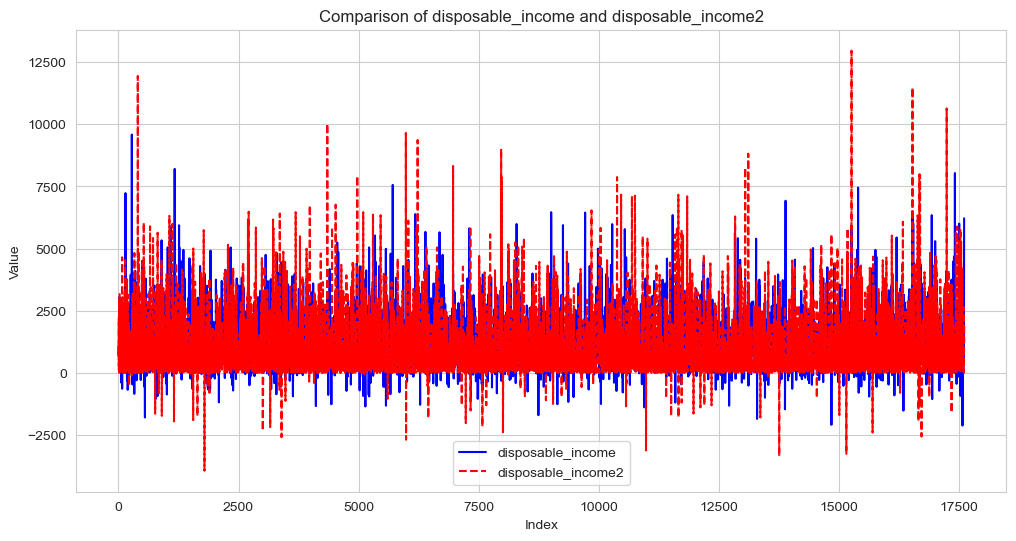

In [69]:
# Plotting the two columns
plt.figure(figsize=(12, 6))
plt.plot(df_all['disposable_income'], label='disposable_income', color='blue')
plt.plot(df_all['disposable_income2'], label='disposable_income2', color='red', linestyle='--')

# Adding title and labels
plt.title('Comparison of disposable_income and disposable_income2')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

In [70]:
print(df_all['disposable_income'].describe())
print(df_all['disposable_income2'].describe())

count    6907.000000
mean     1273.212459
std       946.117822
min     -2123.833333
25%       679.500000
50%      1147.333333
75%      1702.833333
max      9587.791667
Name: disposable_income, dtype: float64
count     6907.000000
mean       905.562239
std       1166.906576
min      -3943.188333
25%        173.077917
50%        478.797500
75%       1263.145417
max      12965.155833
Name: disposable_income2, dtype: float64


In [71]:
df_sum_keep['EDI_difference'] = df_all['disposable_income'] -df_all['disposable_income2']
df_sum_keep['EDI_difference'].describe()

count     4390.000000
mean       362.575373
std       1452.822502
min     -10802.410000
25%       -303.227292
50%        518.227083
75%       1193.801458
max       8988.449167
Name: EDI_difference, dtype: float64

## Comment
> There is a clear difference between EDI from the applicant data to the open banking data. This might be due to the time period that the data was collected (MCF has told us that Applicant data is the most recent).

--------

## Summary Model
This model runs the same random forest as above (where we used Applicant & Bureau datasets) but also uses additional variables from the Summary data sets (in a new merged data set).

In [72]:
cushion = 0.10

def calculate_afford_flag(row):
    afford_flag = (row['disposable_income'] * (1 - cushion)) - row['repayment']
    return afford_flag

df_all['afford_flag'] = df_all.apply(calculate_afford_flag, axis=1)
df_all['afford_flag'] = np.where(df_all['afford_flag'] > 0, 0, 1)

In [73]:
# Drop other unnecessary columns
df_all = df_all.drop(['uuid', 'date_created_x','has_mortgage_x','number_applications',
                          'tax', 'interest_rate', 'date_created_y', 
                      'total_spend','salary_band_10000s','salary_band_5000s', 
                      'clusters'], axis=1)

#Change Rejected column to 1 and 0
df_all['rejected'] = df_all['rejected'].astype(int)
print(df_all['rejected'].info)

#Change has_mortgage column to 1 and 0
df_all['has_mortgage_y'] = df_all['has_mortgage_y'].astype(int)
print(df_all['has_mortgage_y'].info)

# Create binary (dummy) variables
df_all = pd.get_dummies(df_all, columns=['reason', 'employment_status'], drop_first=True)

<bound method Series.info of 5        0
7        0
8        0
9        0
10       0
        ..
17603    0
17604    0
17605    0
17606    0
17607    0
Name: rejected, Length: 6907, dtype: int32>
<bound method Series.info of 5        1
7        0
8        0
9        0
10       0
        ..
17603    0
17604    0
17605    1
17606    1
17607    1
Name: has_mortgage_y, Length: 6907, dtype: int32>


In [74]:
# Calculate the correlation matrix
correlation_matrix = df_all.corr()

# Display the correlation matrix
target_correlation = correlation_matrix['afford_flag'].sort_values(ascending=False)
print(target_correlation)

afford_flag                                    1.000000
rejected                                       0.949709
DTI                                            0.466066
monthly_spending                               0.316257
rent_mortgage_spend                            0.259936
dependants_spend                               0.204198
dependant_number                               0.171640
employment_status_PT_EMPLOYED                  0.107037
total_benefits_last_360_days                   0.100331
repayment                                      0.059625
amount_requested                               0.054458
new_to_credit_on_date_created                  0.044399
has_mortgage_y                                 0.038864
disposable_income2                             0.025528
ccj_flag                                       0.021211
duration_requested                             0.018789
self_employed_flag                             0.014578
employment_status_WORK_AT_HOME                 0

In [75]:
# Drop collerated columns to avoid multicollinearity 
df_all = df_all.drop(['rejected', 'net_salary','employment_status_SELF_EMPLOYED','amount_requested',
                         'annual_salary','monthly_earnings','rent_mortgage_spend',
                         'monthly_spending', 'dependants_spend', 'net_essential_spend_last_360_days',
                      'disposable_income2','disposable_income', 'repayment', 'income_after_repay',
                      'total_income_broad_last_360_days', 'total_benefits_last_360_days', 
                      'net_mortgage_and_rent_spend_last_360_days',
                      'net_groceries_spend_last_360_days', 'net_essential_spend_last_360_days', 
                      'net_bills_and_utilities_spend_last_360_days', 'repayment',
                     ], axis=1)

In [76]:
# Drop columns that are included on missed_payment.
df_all = df_all.drop(['ccj_flag','missed_2+_payments_past_36m', 'o1','o2', 'o3'], axis=1)
df_all['missed_payment'] = np.where(df_all['missed_payment'] != 0, 1, 0)

In [77]:
#Change has_mortgage column to 1 and 0
df_all['has_mortgage_y'] = df_all['has_mortgage_y'].astype(int)

In [78]:
# Define the dependent variable.
y = df_all['afford_flag']

# Define the independent variable.
X = df_all.drop(['afford_flag'], axis=1)

In [79]:
# Add a constant to the X dataframe
X_const = add_constant(X)

# Identify multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i)
                          for i in range(len(X_const.columns))]

# View the DataFrame.
vif_data.sort_values('VIF', ascending=True)

,feature,VIF
19,employment_status_STUDENT,1.003562
12,difference,1.003623
18,employment_status_RETIRED,1.003865
20,employment_status_UNEMPLOYED,1.005614
21,employment_status_WORK_AT_HOME,1.006565
9,net_gambling_spend_last_360_days,1.012849
3,new_to_credit_on_date_created,1.020862
17,employment_status_PT_EMPLOYED,1.021628
6,self_employed_flag,1.028553
8,DTI,1.030661


In [80]:
# Add a constant to the X dataframe
X_const = add_constant(X)

# Create train and test data sets.
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.2, random_state=42)

# Handling Imbalanced Data using SMOTE
#smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Import the MinMaxScaler to normalize the data.
scaler = MinMaxScaler(feature_range=(0, 1))

# Add the X_train_resampled data set to the 'scaler' function.
scaler.fit(X_train_resampled)

# Specify X_train and X_test data sets.
X_train_resampled = scaler.transform(X_train_resampled)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_const.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_const.columns)

# Reset index to ensure that the index starts from 0
y_train_resampled = y_train_resampled.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Logistic Regression model
logmodel = LogisticRegression()
logmodel.fit(X_train_resampled, y_train_resampled)

# Prediction model
y_pred = logmodel.predict(X_test)

# Print classification_report
print(classification_report(y_test, y_pred))

# AUC-ROC for Logistic Regression
y_pred_prob_log = logmodel.predict_proba(X_test)[:, 1]
auc_log = roc_auc_score(y_test, y_pred_prob_log)
print(f"AUC-ROC for Logistic Regression: {auc_log:.2f}")

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      1254
           1       0.33      0.71      0.45       128

    accuracy                           0.84      1382
   macro avg       0.65      0.78      0.68      1382
weighted avg       0.91      0.84      0.86      1382

AUC-ROC for Logistic Regression: 0.87


In [81]:
# Random Forest Classifier
forest = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=2, 
                                min_samples_leaf=2, max_features='auto', bootstrap=True, 
                                n_jobs=-1, random_state=42)
forest.fit(X_train_resampled, y_train_resampled)

# Importance values
forest.feature_importances_

# Feature importances
feature_df = pd.DataFrame({'feature': X_const.columns, 
                           'feature_importnces':forest.feature_importances_}).sort_values(by='feature_importnces',ascending=False)
print(feature_df)

                               feature  feature_importnces
8                                  DTI            0.446030
1                   duration_requested            0.072326
11           avg_balance_last_360_days            0.065566
9     net_gambling_spend_last_360_days            0.051533
16                      reason_vehicle            0.049908
4                    credit_score_100s            0.042485
2                     dependant_number            0.041938
10  avg_overdraft_amount_last_360_days            0.038065
3        new_to_credit_on_date_created            0.035660
14                        reason_other            0.034345
15                     reason_purchase            0.032427
13            reason_home-improvements            0.028289
12                          difference            0.025211
5                       has_mortgage_y            0.020188
6                   self_employed_flag            0.010953
7                       missed_payment            0.0036

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1254
           1       0.44      0.55      0.49       128

    accuracy                           0.89      1382
   macro avg       0.70      0.74      0.71      1382
weighted avg       0.91      0.89      0.90      1382

AUC-ROC for Random Forest: 0.88


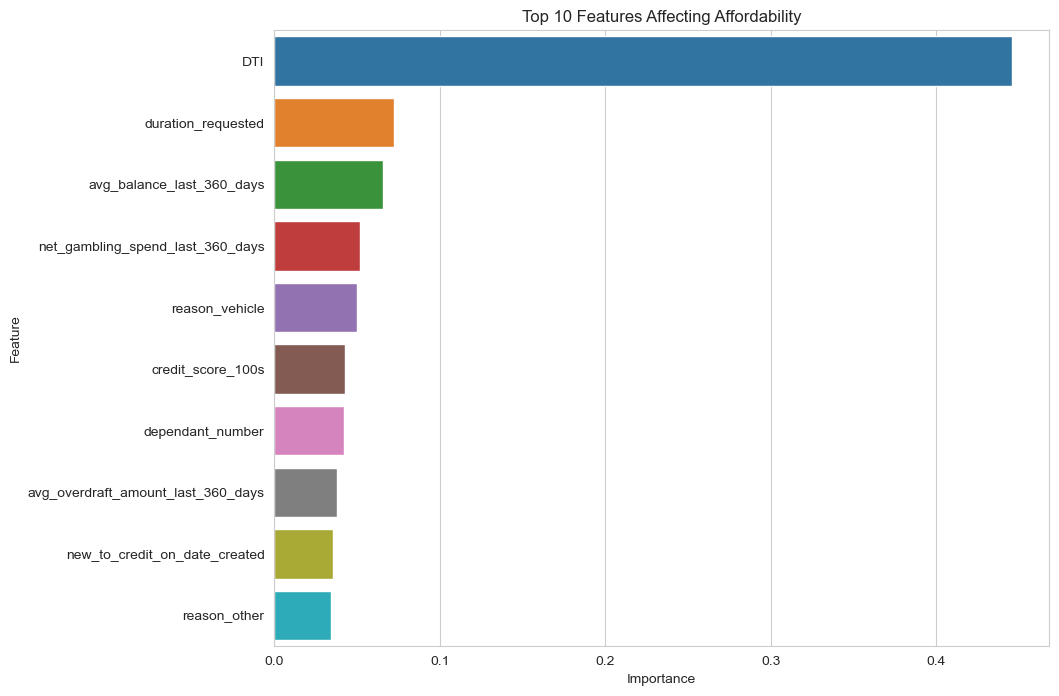

In [82]:
# Prediction model
y_pred_forest = forest.predict(X_test)

# Print classification_report
print(classification_report(y_test, y_pred_forest))

# AUC-ROC for Random Forest
y_pred_prob_forest = forest.predict_proba(X_test)[:, 1]
auc_forest = roc_auc_score(y_test, y_pred_prob_forest)
print(f"AUC-ROC for Random Forest: {auc_forest:.2f}")



# 2. Feature Importance from Random Forest
plt.figure(figsize=(10, 8))
sns.barplot(x='feature_importnces', y='feature', data=feature_df.head(10))
plt.title('Top 10 Features Affecting Affordability')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Comment

**Summary Random Forest model observations**
The random forest model based on Applicant, Bureau and Open Banking data generated a slightly different set of important variables. 

DTI is the most important factor (as on the previous random forest model), however this model's accuracy is lower at 89%, recall at 55% and precision at 44%.

Note that gambling spend and average bank balance show as high factors impacting the afford flag. 
We recommend further investigation on the summary data factors, perhaps using a bigger data sample to test for model accuracy.

Based on the data samples supplied we would recommend using the Applicant & Bureau data set for the random forest model to generate the top 10 most important features.

---------------------

----------------

- Based on the results of the top 10 important features, we created a scorecard.

- Please move to the next Jupiter called: 3.Team8_LSE_EP_Assignment3_Scorecard

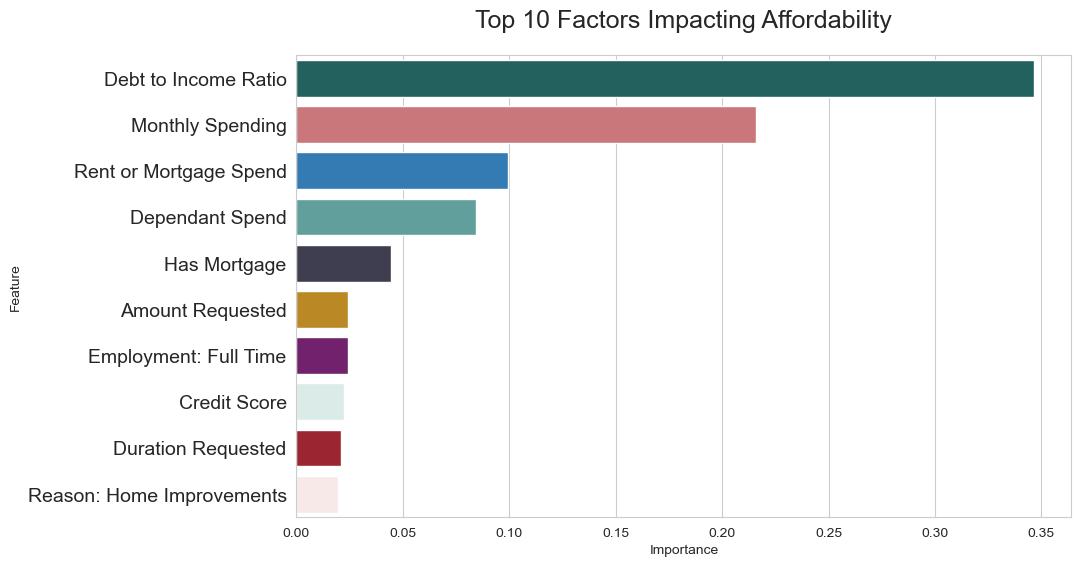